In [1]:
from tqdm import tqdm, trange
from typing import ClassVar, Literal, Tuple  # ClassVar, Literal, Tuple, cast
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.stats as stats

from torchtyping import TensorType as TT
import torch
import torch.nn as nn
from torch.distributions import Distribution, Normal, Beta

from gfn.actions import Actions
from gfn.env import Env
from gfn.gflownet import TBGFlowNet, SubTBGFlowNet
from gfn.modules import GFNModule
from gfn.states import States
from gfn.utils import NeuralNet

Here, we are explore Continuous GFlowNets in an exceedingly simple case: from an initial starting point on the number line, sample a set of positivei increments such that we learn to sample from some reward distribution. Here, that reward distribution will be some mixture of Gaussians. Each step will be sampled from a scaled Beta distribution.

The key difference with Continuous GFlowNets is that they sample some *delta* in a continuous space, instead of discrete actions. Typically, this means your GFlowNet uses a function approximator $f(\cdot)$, which accepts the current state $s_{t}$, to predict the *paramaters of a distribution* $\rho = \{p_1, p_2, ..., p_n\}$. Then your choses distribution $D(\rho)$ is used to sample a real-valued tensor $s_{\Delta} \sim D(\rho)$ which is added to your current state to produce a the next step in the state space $s_{t+1} = s_{t} + s_{\Delta}$ (note, we no longer consider a DAG here, but rather a topological space with distinguished source and sink states).

In our case, we want to increment along the number line in such a way that we learn to sample from some arbitrary multi-modal distribution. So we need a distribution from which to sample these steps. Recall that the probability density function of the beta distribution, for $0 \leq x \leq 1$ or $0 < x < 1$, given two shape parameters $\alpha, \beta > 0$, is

$$f(x;\alpha,\beta) = constant\ \cdot\ x^{\alpha-1}(1-x)^{\beta-1} = \frac{1}{B(\alpha,\beta)} x^{\alpha-1}(1-x)^{\beta-1}$$

, where $B(\alpha,\beta) = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)}$, and $\Gamma(z)$ is the Gamma function, see [here](https://en.wikipedia.org/wiki/Beta_distribution).

This distribution has a nice property for our setup: the distribution is bounded and can be made strictly positive, so each "step" sampled will increment the number line. To take steps larger than one, we can simply also predict a scaling factor $\gamma$ to apply to our beta distribution samples.

In our setup, we will define a multimodal distribution on the 1D line. We will also define a starting point $S_0$, on the number line to the left of all modes by an arbitrary distance. The GFlowNet must sample increments along the number line such that it samples final values along the number line proportionally to the mixture distribution.

We also need to know when to terminate this process, otherwise we never sample a final value. To do so, let's simply include the count value, $t$, in the state $s_t$, and always terminate when $t=5$. There are more sophisitcated ways to do this, but they add complexity, and we want to focus this tutorial on only the core concepts.

Since every state reachable by the backward policy must also be reachable by the forward policy, we need to enforce that the smallest value that can be sampled by the backward policy is $S_0$. The forward policy will naturally satisfy this constraint.



# Defining the Environment

First let's define our environment. We require a few things. First, we need a reward distribution. This will be a mixture of Gaussians on the real number line. The reward at each point will simply be the sum of the PDFs at that point across all elements of the mixture. To keep things simple, we'll enforce that all trajectories are exactly 5 steps. With probabilisitc exit actions, the logic becomes more tricky, though it is often useful in some applications. Finally, we need to define $S_0$, the starting point for all trajectories. This `lower_bound` (aka `lb`) will be defined as a configurable number of standard deviations below the gaussian with the smallest mean value.

For each forward action, we will add the action value to the current state, and increment the step counter. For the backward action, we will substract the action value from the current state, and decrement the step counter.

We're not allowed to go backward beyond $S_0$, and this constraint is handled by the distribution we sample from for the backward policy, detailed later.

/tmp/ipykernel_145438/1097605799.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Normal(torch.tensor(m), torch.tensor(s)) for m, s in zip(mus, self.sigmas)


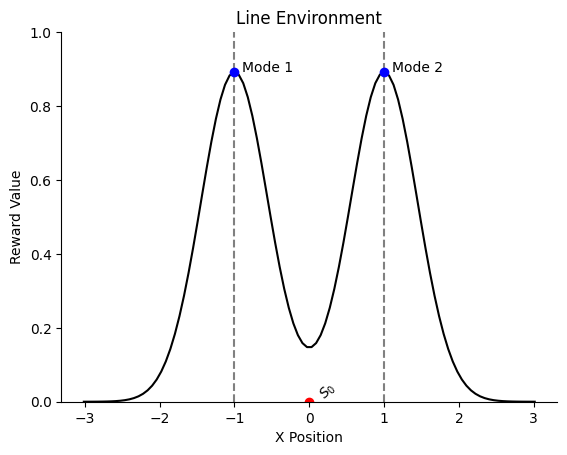

In [2]:
class Line(Env):
    """Line environment."""

    def __init__(
        self,
        mus: list = [-1, 1],
        variances: list = [0.2, 0.2],
        n_sd: float = 4.5,
        init_value: float = 0,
        n_steps_per_trajectory: int = 5,
        device_str: Literal["cpu", "cuda"] = "cpu",
    ):
        assert len(mus) == len(variances)
        self.mus = torch.tensor(mus)
        self.sigmas = torch.tensor([math.sqrt(v) for v in variances])
        self.variances = torch.tensor(variances)
        self.n_sd = n_sd
        self.n_steps_per_trajectory = n_steps_per_trajectory
        self.mixture = [
            Normal(torch.tensor(m), torch.tensor(s)) for m, s in zip(mus, self.sigmas)
        ]

        self.init_value = init_value  # Used in s0.
        self.lb = min(self.mus) - self.n_sd * max(self.sigmas)  # Convienience only.
        self.ub = max(self.mus) + self.n_sd * max(self.sigmas)  # Convienience only.

        assert self.lb < self.init_value < self.ub

        # The state is [x_value, count]. x_value is initalized close to the lower bound.
        s0 = torch.tensor([self.init_value, 0.0], device=torch.device(device_str))
        sf = torch.FloatTensor([float("inf"), float("inf")], ).to(s0.device)
        super().__init__(s0=s0, sf=sf)  # Overwriting the default sf of -inf.

    def make_states_class(self) -> type[States]:
        env = self

        class LineStates(States):
            state_shape: ClassVar[Tuple[int, ...]] = (2,)
            s0 = env.s0  # should be [init value, 0].
            sf = env.sf  # should be [+inf, +inf].

            @classmethod
            def make_random_states_tensor(cls, batch_shape: Tuple[int, ...]) -> TT["batch_shape", 2, torch.float]:
                # Scale [0, 1] values between lower & upper bound.
                scaling = (self.ub - self.lb) + self.lb
                x_val = torch.rand(batch_shape + (1,)) * scaling
                steps = torch.full(batch_shape + (1,), self.n_steps_per_trajectory)
                return torch.cat((x_val, steps), dim=-1, device=env.device)

        return LineStates

    def make_actions_class(self) -> type[Actions]:
        env = self

        class LineActions(Actions):
            action_shape: ClassVar[Tuple[int, ...]] = (1,)  # Does not include counter!
            dummy_action: ClassVar[TT[2]] = torch.tensor([-float("inf")], device=env.device)
            exit_action: ClassVar[TT[2]] = torch.tensor([float("inf")], device=env.device)

        return LineActions

    def maskless_step(self, states: States, actions: Actions) -> TT["batch_shape", 2, torch.float]:
        states.tensor[..., 0] = states.tensor[..., 0] + actions.tensor.squeeze(-1)  # x position.
        states.tensor[..., 1] = states.tensor[..., 1] + 1  # Step counter.
        return states.tensor

    def maskless_backward_step(self, states: States, actions: Actions) -> TT["batch_shape", 2, torch.float]:
        states.tensor[..., 0] = states.tensor[..., 0] - actions.tensor.squeeze(-1)  # x position.
        states.tensor[..., 1] = states.tensor[..., 1] - 1  # Step counter.
        return states.tensor

    def is_action_valid(self, states: States, actions: Actions, backward: bool = False) -> bool:
        """We are only going to prevent taking actions leftward beyond `S_0`."""
        non_exit_actions = actions[~actions.is_exit]
        non_terminal_states = states[~actions.is_exit]
        s0_states_idx = non_terminal_states.is_initial_state

        # Can't take a backward step at the beginning of a trajectory.
        if torch.any(s0_states_idx) and backward:
            return False

        non_s0_states = non_terminal_states[~s0_states_idx].tensor
        non_s0_actions = non_exit_actions[~s0_states_idx].tensor

        return True

    def reward(self, final_states: States) -> TT["batch_shape", torch.float]:
        """Sum of the exponential of each log probability in the mixture."""
        r = torch.zeros(final_states.batch_shape)
        for m in self.mixture:
            r = r + torch.exp(m.log_prob(final_states.tensor[..., 0]))  # x position.

        return r

    def log_reward(self, final_states: States) -> TT["batch_shape", torch.float]:
        return torch.log(self.reward(final_states))

    @property
    def log_partition(self) -> float:
        """Log Partition log of the number of gaussians."""
        return torch.tensor(len(self.mus)).log()


def render(env, validation_samples=None):
    """Renders the reward distribution over the 1D env."""
    x = np.linspace(
        min(env.mus) - env.n_sd * max(env.sigmas),
        max(env.mus) + env.n_sd * max(env.sigmas),
        100,
    )

    d = np.zeros(x.shape)
    for mu, sigma in zip(env.mus, env.sigmas):
        d += stats.norm.pdf(x, mu, sigma)

    fig, ax1 = plt.subplots()

    if not isinstance(validation_samples, type(None)):
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis.
        ax2.hist(
            validation_samples.tensor[:,0].cpu().numpy(),
            bins=100,
            density=False,
            alpha=0.5,
            color="red",
        )
        ax2.set_ylabel("Samples", color="red")
        ax2.tick_params(axis="y", labelcolor="red")

    ax1.plot(x, d, color="black")

    # Adds the modes.
    for mu in env.mus:
        ax1.axvline(mu, color="grey", linestyle="--")

    # S0
    ax1.plot([env.init_value], [0], 'ro')
    ax1.text(env.init_value + 0.1, 0.01, "$S_0$", rotation=45)

    # Means
    for i, mu in enumerate(env.mus):
        idx = abs(x - mu.numpy()) == min(abs(x - mu.numpy()))
        ax1.plot([x[idx]], [d[idx]], 'bo')
        ax1.text(x[idx] + 0.1, d[idx], "Mode {}".format(i + 1), rotation=0)

    ax1.spines[['right', 'top']].set_visible(False)
    ax1.set_ylabel("Reward Value")
    ax1.set_xlabel("X Position")
    ax1.set_title("Line Environment")
    ax1.set_ylim(0, 1)
    plt.show()

# Set up our simple environment.
env = Line(mus=[-1, 1], variances=[0.2, 0.2], n_sd=4.5, init_value=0, n_steps_per_trajectory=5)
render(env)


# Defining Action Distributions

We're going to use Trajectory Balance, so we first need to define our forward and backward policy. The first step is to define the distribution we will use for sampling forward and backward actions. Luckily, the Beta distribution itself is already defined. We just need to make a slight extension of it which handles exits (for the forward policy) and the scaling factor:

In [3]:
class ScaledGaussianWithOptionalExit(Distribution):
    """Extends the Beta distribution by considering the step counter. When sampling,
    the step counter can be used to ensure the `exit_action` [inf, inf] is sampled.
    """
    def __init__(
        self,
        states: TT["n_states", 2],  # Tensor of [x position, step counter].
        mus: TT["n_states", 1],  # Parameter of Gaussian distribution.
        scales: TT["n_states", 1],  # Parameter of Gaussian distribution.
        forward: bool,  # True for forward policies.
        n_steps: int = 5,
    ):
        self.states = states
        self.n_steps = n_steps
        self.dist = Normal(mus, scales)
        self.exit_action = torch.FloatTensor([float("inf")]).to(states.device)
        self.forward = forward

    def sample(self, sample_shape=()):
        actions = self.dist.sample(sample_shape)

        # For any state which is at the terminal step, assign the exit action.
        if self.allow_exit:
            exit_mask = torch.where(
                self.states[..., -1].tensor >= self.n_steps,  # This is the step counter.
                torch.ones(sample_shape + (1,)),
                torch.zeros(sample_shape + (1,)),
            ).bool()
            actions[exit_mask] = self.exit_action

        return actions

    def log_prob(self, sampled_actions):
        """TODO"""
        # These are the exited states.
        exit = torch.all(sampled_actions == torch.full_like(sampled_actions[0], float("inf")), 1)  # This is the exit action
        logprobs = torch.full_like(sampled_actions, fill_value=-float("inf"))

        if self.forward:  # Forward: handle exit actions.
            if sum(~exit) > 0:
                # print("samples_actions_shape={}, logprobs_shape={}, exit_shape={}".format(
                #     sampled_actions.shape, logprobs.shape, exit.shape))
                logprobs[~exit] = self.dist.log_prob(sampled_actions)[~exit]
            logprobs[exit] = torch.log(torch.tensor(1.0))  # p(exit) == 1 at n_steps, else 0.
        else:  # Backward: handle the transition from S1 -> S0.
            logprobs = self.dist.log_prob(sampled_actions)

        return logprobs.squeeze(-1)

Next, we need a neural network which will predict, at each step, the parameters of this distribution, for both the forward and backward policies. Note the logic which enforces that no backward step can go beyond the $S_0$ value.

In [4]:
class GaussianStepNeuralNet(NeuralNet):
    """A deep neural network for the forward and backward policy."""
    def __init__(
            self,
            hidden_dim: int,
            n_hidden_layers: int,
            backward: bool,
            s0_val: float = -float("inf"),
            policy_std_min: float = 0.1,
            policy_std_max: float = 1,
        ):
        """Instantiates the neural network for the forward policy."""
        assert policy_std_min > 0
        assert policy_std_min <  policy_std_max

        self.input_dim = 2  # [x_pos, counter]
        self.output_dim = 2   # [mus, scales]
        self.s0_val = s0_val
        self.backward = backward
        self.policy_std_min = policy_std_min
        self.policy_std_max = policy_std_max

        if backward:
            assert not math.isinf(s0_val)

        super().__init__(
            input_dim=self.input_dim,
            hidden_dim=hidden_dim,
            n_hidden_layers=n_hidden_layers,
            output_dim=self.output_dim,
            activation_fn="elu",
        )

    def forward(self, preprocessed_states: TT["batch_shape", 2, float]) -> TT["batch_shape", "3"]:
        assert preprocessed_states.ndim == 2
        out = super().forward(preprocessed_states)  # [..., 2]: represents mean & std.

        # When forward, the mean can take any value. The variance must be > 0.1
        minmax_norm = (self.policy_std_max - self.policy_std_min) + self.policy_std_min
        out[..., 1] = torch.sigmoid(out[..., 1]) * minmax_norm  # Scales / Variances.

        if self.backward:
            distance_to_s0 = preprocessed_states[..., 0] - self.s0_val

            # At backward_step = 1, where the next step is s0, the only valid action
            # to to jump directly to s0.
            idx_to_s0 = preprocessed_states[..., 1] == 1  # s_1 -> s_0.
            if sum(idx_to_s0) > 0:
                out[idx_to_s0, 0] = distance_to_s0[idx_to_s0]
                out[idx_to_s0, 1] = 1/(2*np.pi)**0.5  # Gaussian PDF scaling factor.

        return out

Next, we need an `Estimator` that holds our function approximator. This accepts states, and returns a distribution we can sample from:

In [5]:
class StepEstimator(GFNModule):
    """Estimator for P_F and P_B of the Line environment."""
    def __init__(self, env: Line, module: torch.nn.Module, forward: bool):
        super().__init__(module)
        self.forward = forward

    def expected_output_dim(self) -> int:
        return 2  # [locs, scales].

    def to_probability_distribution(
        self,
        states: States,
        module_output: TT["batch_shape", "output_dim", float],
        scale_factor = 1,
    ) -> Distribution:
        # First, we verify that the batch shape of states is 1
        assert len(states.batch_shape) == 1
        assert module_output.shape == states.batch_shape + (2,)  # [locs, scales].
        locs, scales = torch.split(module_output, [1, 1], dim=-1)

        return ScaledGaussianWithOptionalExit(
            states,
            locs,
            scales + scale_factor,  # Increase this value to induce exploration.
            allow_exit=self.forward,
            n_steps=env.n_steps_per_trajectory,
        )

In [6]:
def get_scheduler(optim, n_iter, n_steps_scheduler=1500, scheduler_gamma=0.5):
    return torch.optim.lr_scheduler.MultiStepLR(
        optim,
        milestones=[
            i * n_steps_scheduler
            for i in range(1, 1 + int(n_iter / n_steps_scheduler))
        ],
        gamma=scheduler_gamma,
    )

def train(seed=4444, n_trajectories=3e6, batch_size=128, lr_base=1e-3, gradient_clip_value=10, n_logz_resets=0):
    # Reproducibility.
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)

    device_str = "cuda" if torch.cuda.is_available() else "cpu"
    n_iterations = int(n_trajectories // batch_size)
    logz_reset_interval = 50
    logz_reset_count = 0


    # TODO: Add in the uniform pb demo?
    #uniform_pb = False
    #
    #if uniform_pb:
    #    pb_module = BoxPBUniform()
    #else:
    #    pb_module = BoxPBNeuralNet(hidden_dim, n_hidden_layers, n_components)

    # 3. Create the optimizer and scheduler.
    optimizer = torch.optim.Adam(pf_module.parameters(), lr=lr_base)
    logZ = dict(gflownet.named_parameters())["logZ"]
    optimizer.add_param_group({"params": [logZ], "lr": lr_base * 10})

    # TODO:
    # if not uniform_pb:
    #     optimizer.add_param_group({"params": pb_module.parameters(), "lr": lr_base})
    # optimizer.add_param_group({"params": logFmodule.parameters(), "lr": lr_logF})

    scheduler = get_scheduler(
        optimizer,
        n_iterations,
        n_steps_scheduler=int(n_iterations / 2),
        scheduler_gamma=0.5,
    )

    # TODO:
    # 4. Sample from the true reward distribution, and fit a KDE to the samples.
    n_val_samples = 1000
    # samples_from_reward = sample_from_reward(env, n_samples=n_val_samples)
    # true_kde = KernelDensity(kernel="exponential", bandwidth=0.1).fit(
    #     samples_from_reward
    # )

    # Training loop!
    validation_interval = 1e4
    states_visited = 0
    jsd = float("inf")
    tbar = trange(n_iterations, desc="Training iter")
    scale_schedule = np.linspace(2, 0, n_iterations)
    for iteration in tbar:

        if logz_reset_count < n_logz_resets and iteration % logz_reset_interval == 0:
            gflownet.logZ = torch.nn.init.constant_(gflownet.logZ, 0)
            print("resetting logz")
            logz_reset_count += 1

        # Off Policy Sampling.
        trajectories = gflownet.sample_trajectories(
            env,
            n_samples=batch_size,
            scale_factor=scale_schedule[iteration],
        )
        training_samples = gflownet.to_training_samples(trajectories)

        optimizer.zero_grad()
        loss = gflownet.loss(env, training_samples)
        loss.backward()

        # LESSON: Clipping
        for p in gflownet.parameters():
            if p.ndim > 0 and p.grad is not None:  # We do not clip logZ grad.
                p.grad.data.clamp_(-gradient_clip_value, gradient_clip_value).nan_to_num_(0.0)

        optimizer.step()
        scheduler.step()

        states_visited += len(trajectories)
        assert logZ is not None

        #to_log = {"loss": loss.item(), "states_visited": states_visited}
        # logZ_info = ""
        #to_log.update({"logZdiff": env.log_partition - logZ.item()})
        # logZ_info = f"logZ: {:.2f}, "
        #print(logFmodule.logZ_value)
        #print(gflownet.logZ)

        tbar.set_description("Training iter {}: (states visited={}, loss={:.3f}, estimated logZ={:.3f}, true logZ={:.3f}, JSD={}, LR={})".format(
            iteration,
            states_visited,
            loss.item(),
            logZ.item(),
            env.log_partition,
            jsd,
            optimizer.param_groups[0]['lr'],
            )
        )
        if iteration % validation_interval == 0:
            validation_samples = gflownet.sample_terminating_states(env, n_val_samples)
            # kde = KernelDensity(kernel="exponential", bandwidth=0.1).fit(
            #     validation_samples.tensor.detach().cpu().numpy()
            # )
            # jsd = estimate_jsd(kde, true_kde)
            #to_log.update({"JSD": jsd})

    return jsd

# Forward and backward policy estimators. We pass the lower bound from the env here.
hid_dim = 32

pf_module = GaussianStepNeuralNet(hidden_dim=hid_dim, n_hidden_layers=2, backward=False)
pf_estimator = StepEstimator(
    env,
    pf_module,
    forward = True,
)

pb_module = GaussianStepNeuralNet(hidden_dim=hid_dim, n_hidden_layers=2, backward=True, s0_val=env.init_value)
pb_estimator = StepEstimator(
    env,
    pb_module,
    forward = False,
)

gflownet = TBGFlowNet(
    pf=pf_estimator,
    pb=pb_estimator,
    off_policy=True,
    init_logZ=0.0,
)

# Magic hyperparameters: lr_base=4e-2, n_trajectories=3e6, batch_size=2048
train(lr_base=1e-3, n_trajectories=1e6, batch_size=1024)  # I started training this with 1e-3 and then reduced it.
validation_samples = gflownet.sample_terminating_states(env, 10000)
render(env, validation_samples=validation_samples)

TypeError: StepEstimator.__init__() got an unexpected keyword argument 'allow_exit'

steps per trajectory: 5


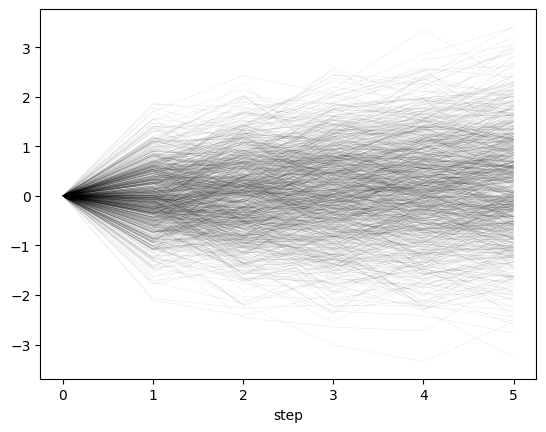

In [ ]:
print("steps per trajectory: {}".format(env.n_steps_per_trajectory))
trajs = gflownet.sample_trajectories(env, n_samples=1000)
trajs = torch.stack( [ trajs[i].states.tensor.view(-1,2)[:-1,0] for i in range(1000) ])
for i in range(1000):
    plt.plot(
        np.arange(env.n_steps_per_trajectory + 1),
        trajs[i].cpu().numpy(),
        alpha=0.3,
        linewidth=0.1,
        color='black'
    )
plt.xlabel('step')
plt.show()

/tmp/ipykernel_143291/2351962954.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Normal(torch.tensor(m), torch.tensor(s)) for m, s in zip(mus, self.sigmas)


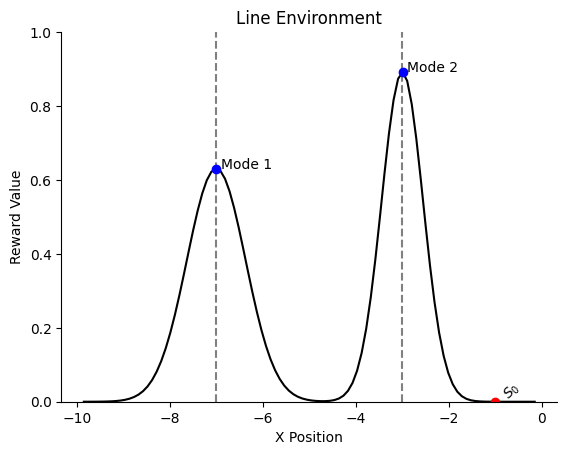

In [ ]:
#env = Line(mus=[-1, 1], variances=[1, 1], n_sd=4.5, init_value=0, n_steps_per_trajectory=5)
env = Line(mus=[-7, -3], variances=[0.4, 0.2], n_sd=4.5, init_value=-1, n_steps_per_trajectory=5)

render(env)

In [ ]:
# Forward and backward policy estimators. We pass the lower bound from the env here.
hid_dim = 32

pf_module = GaussianStepNeuralNet(hidden_dim=hid_dim, n_hidden_layers=2, backward=False)
pf_estimator = StepEstimator(
    env,
    pf_module,
    allow_exit = True,
)

pb_module = GaussianStepNeuralNet(hidden_dim=hid_dim, n_hidden_layers=2, backward=True, s0_val=env.init_value)
pb_estimator = StepEstimator(
    env,
    pb_module,
    allow_exit = False,
)

gflownet = TBGFlowNet(
    pf=pf_estimator,
    pb=pb_estimator,
    off_policy=True,  # No replay buffer.
    init_logZ=0.0,
)

# Magic hyperparameters: lr_base=4e-2, n_trajectories=3e6, batch_size=2048
train(lr_base=4e-2,   # I started training this with 1e-3 and then reduced it.
      n_trajectories=1e6,
      batch_size=2048,
      gradient_clip_value=10,
      n_logz_resets = 0,
)

Training iter 487: (states visited=999424, loss=15.941, estimated logZ=-7.198, true logZ=0.693, JSD=inf, LR=0.01): 100%|██████████| 488/488 [02:22<00:00,  3.42it/s] 


inf

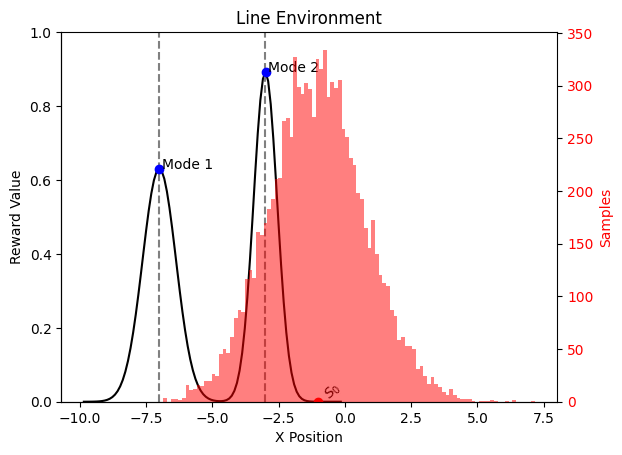

In [ ]:
validation_samples = gflownet.sample_terminating_states(env, 10000)
render(env, validation_samples=validation_samples)

In [ ]:
gflownet.logZ = torch.nn.init.constant_(gflownet.logZ, 1)